# The Quick, Draw! Dataset

The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located. You can browse the recognized drawings on quickdraw.withgoogle.com/data or download the dataset from https://console.cloud.google.com/storage/browser/quickdraw_dataset/?pli=1.  

The architecture was ported across from the tutorial <a href='https://www.tensorflow.org/versions/master/tutorials/recurrent_quickdraw'>Recurrent Neural Networks for Drawing Classification</a> (associated repo available <a href='https://github.com/tensorflow/models/tree/master/tutorials/rnn/quickdraw'>here</a>); of which many of the details have been used here.  

<img src='https://github.com/googlecreativelab/quickdraw-dataset/raw/master/preview.jpg'/>

--- 

In [1]:
import keras 
keras.__version__

/Users/admin/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.2'

In [12]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import os
import pickle 

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [4]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

from keras.utils import plot_model

from keras import preprocessing
from keras.preprocessing import image

--- 

In [5]:
#DATASET_DIR = '/Users/Joshua.Newnham/Documents/Data/quickdraw_dataset/sketchrnn_training_data/'
#DATASET_DIR = '/quickdraw_sketches/'
DATASET_DIR = '/Users/admin/Desktop/JN/data/'
TRAINING_PARTS = 5 

In [17]:
EPOCHS = 1000
BATCH_SIZE = 512 
MAX_SEQ_LEN = 75
CLASSES = 172
NUM_RNN_LAYERS = 3 
NUM_RNN_NODES = 128
NUM_CONV = [48, 64, 96, 128]
CONV_LEN = [5, 5, 3, 3]
DROPOUT = 0.3

--- 

In [19]:
def plot_accuracy_loss(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    
    print("{} {} {} {}".format(len(acc), len(val_acc), len(loss), len(val_loss)))

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [8]:
def batch(x, y, batch_size=BATCH_SIZE):
    return x.reshape(batch_size, -1, 3), y

In [9]:
def pad_stroke_sequence(x, max_len=MAX_SEQ_LEN):
    padded_x = np.zeros((x.shape[0], max_len, 3), dtype=np.float32)
    for i in range(x.shape[0]):
        X = x[i]
        if X.shape[0] > max_len:
            X = X[:max_len, :]
        elif X.shape[0] < max_len:
            padding = np.array([[0,0,0]] * (max_len-X.shape[0]), dtype=np.float32)            
            X = np.vstack((padding, X))
            
        padded_x[i] = X
        
    return padded_x

--- 

In [19]:
def create_model(input_shape=(MAX_SEQ_LEN, 3), 
                 num_conv=NUM_CONV, 
                 conv_len=CONV_LEN, 
                 dropout=DROPOUT, 
                 batch_size=BATCH_SIZE, 
                 num_rnn_layers=NUM_RNN_LAYERS, 
                 num_rnn_nodes=NUM_RNN_NODES, 
                 num_classes=CLASSES):
    
    model = models.Sequential() 
    for i, filters in enumerate(num_conv):
        if i == 0:
            # TODO: feasible to use a TimeDistributed wrapper here? https://keras.io/layers/wrappers/
            model.add(
                layers.Conv1D(filters=filters, 
                              kernel_size=conv_len[i], 
                              activation=None, 
                              strides=1, 
                              padding='same', 
                              name='conv1d_{}'.format(i), input_shape=input_shape))
        else:
            model.add(layers.Dropout(dropout, name="dropout_{}".format(i)))
            model.add(layers.Conv1D(filters=filters, 
                                    kernel_size=conv_len[i], 
                                    activation=None, 
                                    strides=1, 
                                    padding='same', 
                                    name='conv1d_{}'.format(i)))
      
    for i in range(num_rnn_layers):
        model.add(layers.Bidirectional(layers.LSTM(units=num_rnn_nodes, 
                                                   return_sequences=True, 
                                                   recurrent_dropout=dropout), 
                                       name="lstm_{}".format(i)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes, activation="softmax"))
    
                      
    return model 

In [11]:
def train(model, 
          train_x_files, train_y_files, valid_x_files, valid_y_files, 
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          max_seq_len=MAX_SEQ_LEN, 
          load_previous_weights=True, model_weights_file="output/quickdraw_weights.h5"):
    
    # load previous weights (if applicable)
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=1)
    
    # compile model 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    history_file = "{}_history.pickle".format(model_weights_file.replace(".h5", ""))
    
    if os.path.isfile(history_file):
        with open(history_file, 'rb') as f:
            accumulated_history = pickle.load(f)
    else:
        accumulated_history = {
            'acc': [], 
            'val_acc': [], 
            'loss': [], 
            'val_loss': []
        }                        
    
    for e in range(epochs):
        for i in range(len(train_x_files)):
            # load data for this iteration 
            train_x = np.load(train_x_files[i])
            train_y = np.load(train_y_files[i])
            
            valid_x = np.load(valid_x_files[i])
            valid_y = np.load(valid_y_files[i])
    
            # prepare training and validation data 
            train_x = pad_stroke_sequence(train_x)
            valid_x = pad_stroke_sequence(valid_x)        
    
            history = model.fit(train_x, train_y,
                                batch_size=batch_size, 
                                epochs=1,
                                validation_data=(valid_x, valid_y), 
                                shuffle=True, 
                                callbacks=[checkpoint])
        
            accumulated_history['acc'] += history.history['acc']
            accumulated_history['val_acc'] += history.history['val_acc']
            accumulated_history['loss'] += history.history['loss']
            accumulated_history['val_loss'] += history.history['val_loss'] 
            
            with open(history_file, 'wb') as f:
                pickle.dump(accumulated_history, f)
    
    return model, accumulated_history 

### Load training and validation data 

In [12]:
# Load files 

train_x_files = [] 
train_y_files = []
valid_x_files = [] 
valid_y_files = []

for part_num in range(1, TRAINING_PARTS+1):
    train_x_files.append(os.path.join(DATASET_DIR, "train_{}_x.npy".format(part_num)))
    train_y_files.append(os.path.join(DATASET_DIR, "train_{}_y.npy".format(part_num)))
    valid_x_files.append(os.path.join(DATASET_DIR, "validation_{}_x.npy".format(part_num)))
    valid_y_files.append(os.path.join(DATASET_DIR, "validation_{}_y.npy".format(part_num)))

In [13]:
train_1_x = np.load(train_x_files[0])
train_1_y = np.load(train_y_files[0])
padded_train_1_x = pad_stroke_sequence(train_1_x)

print("train_1_x {}, train_1_y {}, padded_train_1_x {}".format(
    train_1_x.shape, 
    train_1_y.shape, 
    padded_train_1_x.shape))

train_1_x (344000,), train_1_y (344000, 172), padded_train_1_x (344000, 75, 3)


In [14]:
valid_1_x = np.load(valid_x_files[0])
valid_1_y = np.load(valid_y_files[0])
padded_valid_1_x = pad_stroke_sequence(valid_1_x)

print("valid_1_x {}, valid_1_y {}, padded_valid_1_x {}".format(
    valid_1_x.shape, 
    valid_1_y.shape, 
    padded_valid_1_x.shape))

valid_1_x (34400,), valid_1_y (34400, 172), padded_valid_1_x (34400, 75, 3)


### Create model and train 

In [30]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_0 (Conv1D)            (None, 75, 48)            768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 48)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 64)            15424     
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 96)            18528     
_________________________________________________________________
dropout_3 (Dropout)          (None, 75, 96)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 75, 128)           36992     
__________

In [31]:
model, training_history = train(model, 
                                train_x_files=train_x_files, 
                                train_y_files=train_y_files, 
                                valid_x_files=valid_x_files, 
                                valid_y_files=valid_y_files, 
                                load_previous_weights=True, 
                                model_weights_file="quickdraw_weights_201801181834.h5")

Train on 344000 samples, validate on 34400 samples
Epoch 1/1
344000/344000 [==============================] - 3988s 12ms/step - loss: 3.0310 - acc: 0.3087 - val_loss: 1.9418 - val_acc: 0.5145
Train on 344000 samples, validate on 34400 samples
Epoch 1/1
344000/344000 [==============================] - 3890s 11ms/step - loss: 1.7117 - acc: 0.5634 - val_loss: 1.3766 - val_acc: 0.6425
Train on 344000 samples, validate on 34400 samples
Epoch 1/1
344000/344000 [==============================] - 3893s 11ms/step - loss: 1.4078 - acc: 0.6337 - val_loss: 1.2576 - val_acc: 0.6708
Train on 344000 samples, validate on 34400 samples
Epoch 1/1
344000/344000 [==============================] - 3890s 11ms/step - loss: 1.2502 - acc: 0.6717 - val_loss: 1.0950 - val_acc: 0.7113
Train on 344000 samples, validate on 34400 samples
Epoch 1/1
344000/344000 [==============================] - 3890s 11ms/step - loss: 1.1601 - acc: 0.6938 - val_loss: 1.0532 - val_acc: 0.7213
Train on 344000 samples, validate on 344

Train on 344000 samples, validate on 34400 samples
Epoch 1/1
344000/344000 [==============================] - 3947s 11ms/step - loss: 0.4610 - acc: 0.8681 - val_loss: 0.8317 - val_acc: 0.7970
Train on 344000 samples, validate on 34400 samples
Epoch 1/1
138752/344000 [===========>..................] - ETA: 38:03 - loss: 0.4587 - acc: 0.8687

KeyboardInterrupt: 

86 86 86 86


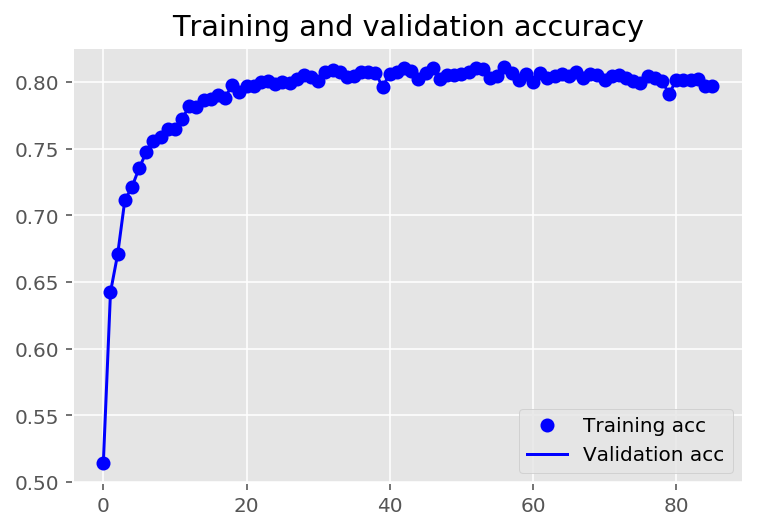

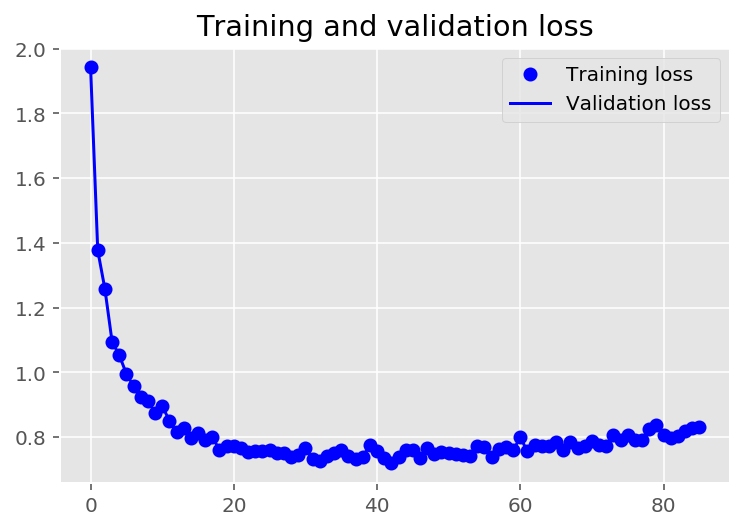

In [21]:
with open('{}_history.pickle'.format('output/quickdraw_weights_201801181834'), 'rb') as f:
    training_history = pickle.load(f)
plot_accuracy_loss(training_history)